In [ ]:
#!pip install qutip==4.7.6 -q
# Remember to restart the kernel after installing the package

# **CUDA-Q Basics**

This notebook is designed for learning the fundamental concepts of quantum computing, the motivation for quantum programming, and the CUDA-Q platform. It sets the stage for hands-on exploration with single and multi-qubit systems, quantum gates, and measurement. Simply set up CUDA-Q by importing `cudaq` along with necessary libraries:

In [2]:
import cudaq
import numpy as np

## Learning Objectives

1. **Quantum States** and **Visualization**
2. **Single-Qubit Quantum Programs**: Gate Operations, Superposition, and Measurements
3. **Multi-Qubit Programming** with Entanglement
4. **Nested Quantum Kernels**
5. **Advanced CUDA-Q Kernels**: Adjoint, Conditionals, and Variational Algorithms

---

## 1. Quantum States and Visualization

- Quantum state with CUDA-Q kernal
- Bloch sphere representation
- Visualizing quantum states

### Example: Defining and Visualizing the Minus State


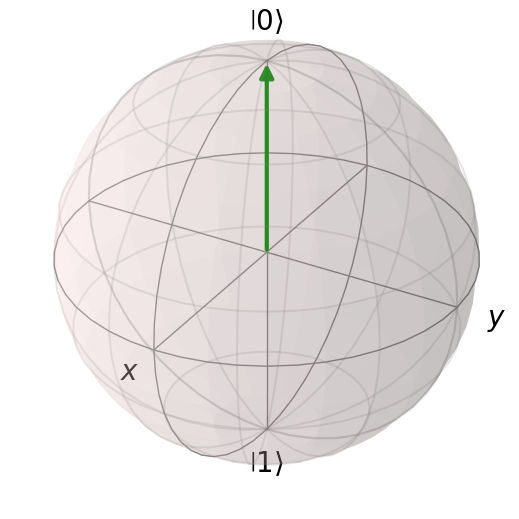

In [3]:
# Define coefficients for the zero state: |0⟩
c = [complex(1, 0), complex(0, 0)]

@cudaq.kernel
def zero_state():
    q = cudaq.qvector(c)


# Visualize the state on the Bloch sphere
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(zero_state))
cudaq.show(sphere)

## 2. Single-Qubit Quantum Programs

- Structure of a quantum program
- Bit flip (X gate)
- Superposition (Hadamard gate)
- Measurement and sampling

### Example: Bit Flip Operation


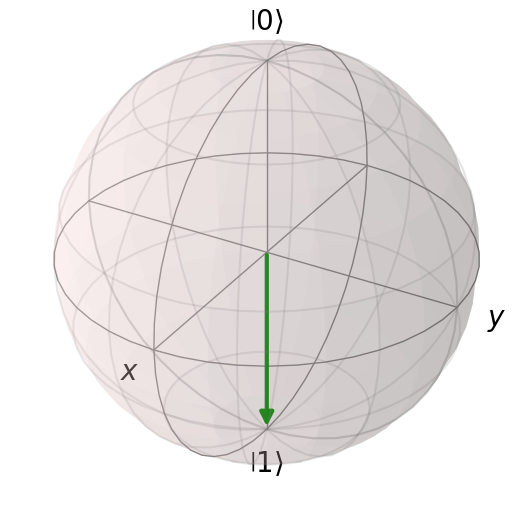

Result from sampling 1000 times: { 1:1000 }

Most probable result: 1
Measured with probability 1.0


In [4]:
@cudaq.kernel
def bitflip():
    qubit = cudaq.qubit()
    x(qubit)


# Visualize the state after the X gate
sphere = cudaq.add_to_bloch_sphere(cudaq.get_state(bitflip))
cudaq.show(sphere)

# Sample the kernel
shots = 1000
result = cudaq.sample(bitflip, shots_count=shots)
print(f"Result from sampling {shots} times: {result}")
print(f"Most probable result: {result.most_probable()}")
print(f"Measured with probability {result.probability(result.most_probable())}")

For all supported gate operations, please kindly refer to this [page](https://nvidia.github.io/cuda-quantum/latest/api/default_ops.html#). Feel free to try experimenting with other quantum gates to see how they affect the qubit state.

### Example: Superposition and Measurement

- Hadamard gate to create |+⟩ = (1/√2)|0⟩ + (1/√2)|1⟩
- Sampling to observe probabilistic outcomes

In [5]:
@cudaq.kernel
def plus_kernel():
    qubit = cudaq.qubit()
    h(qubit)
    mz(qubit)


print(cudaq.draw(plus_kernel))

shots = 1000
result = cudaq.sample(plus_kernel, shots_count=shots)
print("The sampling result:", result)

     ╭───╮
q0 : ┤ h ├
     ╰───╯

The sampling result: { 0:502 1:498 }



### (Optional) Example: Single Qubit U3 Gate

**U3 gate** is a Universal single-qubit rotation with matrix form:
$$
U3(\theta, \phi, \lambda) = 
\begin{bmatrix}
\cos\left(\frac{\theta}{2}\right) & -e^{i\lambda} \sin\left(\frac{\theta}{2}\right) \\
e^{i\phi} \sin\left(\frac{\theta}{2}\right) & e^{i(\phi + \lambda)} \cos\left(\frac{\theta}{2}\right)
\end{bmatrix}
$$

**Special cases**: 
  - `u3(π/2, 0, π)` = Hadamard gate
  - `u3(π, 0, π)` = Pauli-X gate

Here we can use the CUDA-Q built-in `u3`operation:

=== U3 Implementation of Hadamard Gate ===
The sampling result: { 0:487 1:513 }

=== U3 Implementation of Pauli-X Gate ===
The sampling result: { 1:1000 }


=== Arbitrary State Vector ===
State amplitudes: [ 0.707+0.j  -0.5  -0.5j]


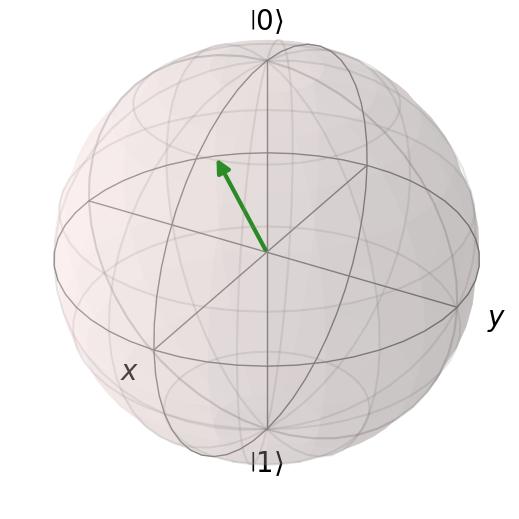

In [6]:
@cudaq.kernel
def u3_state(theta: float, phi: float, lam: float):
    qubit = cudaq.qubit()
    u3(theta, phi, lam, qubit)

# Create Hadamard gate using U3
print("=== U3 Implementation of Hadamard Gate ===")
counts = cudaq.sample(u3_state, np.pi/2, 0.0, np.pi)
print(f"The sampling result: {counts}")

# Create Pauli-X gate using U3
print("=== U3 Implementation of Pauli-X Gate ===") 
counts = cudaq.sample(u3_state, np.pi, 0.0, np.pi)
print(f"The sampling result: {counts}")

# Demonstrate state vector preparation
print("\n=== Arbitrary State Vector ===")
state = cudaq.get_state(u3_state, -np.pi/2, np.pi/4, -np.pi/3)
print(f"State amplitudes: {np.round(state, 3)}")

sphere = cudaq.add_to_bloch_sphere(state)
cudaq.show(sphere)

### (Optional) Example: Custom Operation for Square Root of X Gate

Square Root of NOT (√X) Gate
- **Definition**: A quantum gate where $(\sqrt{X})^2 = X$
- **Property**: Applying it twice flips the qubit (like the X gate)
- **Matrix form**:  
  $$
  \sqrt{X} = 
  \begin{bmatrix}
  \frac{1+i}{2} & \frac{1-i}{2} \\
  \frac{1-i}{2} & \frac{1+i}{2}
  \end{bmatrix}
  $$

The `cudaq.register_operation` function allows you to register custom quantum operations with their unitary matrices, creating reusable custom gates that extend CUDA-Q's built-in gate set and can be used like standard gates in quantum kernels.


In [7]:
# Step 1: Define the unitary matrix for square root of X (NOT) gate
sqrt_x_matrix = np.array([
    [(1 + 1j)/2, (1 - 1j)/2],
    [(1 - 1j)/2, (1 + 1j)/2]
], dtype=complex)

# Step 2: Register the custom operation with CUDA-Q
cudaq.register_operation("sqrt_x", sqrt_x_matrix)

# Step 3: Verify (√X)² = X mathematically
x_gate = np.array([[0, 1], [1, 0]], dtype=complex)
sqrt_x_squared = sqrt_x_matrix @ sqrt_x_matrix
print(f"Verification: (√X)² equals X? {np.allclose(sqrt_x_squared, x_gate)}")

# Step 4: Use the custom gate in CUDA-Q kernels
@cudaq.kernel
def sqrt_x_twice():
    """Apply custom √X gate twice"""
    qubit = cudaq.qubit()
    sqrt_x(qubit)
    sqrt_x(qubit) 
    mz(qubit)

@cudaq.kernel
def x_gate():
    """Apply X gate once for comparison"""
    qubit = cudaq.qubit()
    x(qubit)
    mz(qubit)

# Step 5: Test and compare results
print("\n=== Quantum Circuit Testing ===\n")
sqrt_x_results = cudaq.sample(sqrt_x_twice, shots_count=1000)
x_results = cudaq.sample(x_gate, shots_count=1000)

print(f"√X applied twice: {sqrt_x_results}")
print(f"X applied once:   {x_results}")

Verification: (√X)² equals X? True

=== Quantum Circuit Testing ===

√X applied twice: { 1:1000 }

X applied once:   { 1:1000 }



## 3. Multi-Qubit Programming with Entanglement

- `cudaq.qvector` for multiple qubits and CNOT gates
- Entanglement demonstration

### Example: Bell State (Entanglement)

In [8]:
@cudaq.kernel
def bell_state():
    q = cudaq.qvector(2)
    h(q[0])
    x.ctrl(q[0], q[1])
    mz(q)


print(cudaq.draw(bell_state))

shots = 1000
result = cudaq.sample(bell_state, shots_count=shots)
print("The sampling result:", result)

     ╭───╮     
q0 : ┤ h ├──●──
     ╰───╯╭─┴─╮
q1 : ─────┤ x ├
          ╰───╯

The sampling result: { 00:477 11:523 }



## 4. Nested CUDA-Q Kernels

- **Modular programming**: Define reusable subkernels that can be called within other kernels
- **Benefits**: Improves code reusability and simplifies complex quantum circuits

In [9]:
@cudaq.kernel
def minus(qubit: cudaq.qubit):
    x(qubit)
    h(qubit)

@cudaq.kernel
def xgate(qubits: cudaq.qvector):
    x(qubits)

@cudaq.kernel
def nested_quantum_kernel(num_qubits: int):
    qvector = cudaq.qvector(num_qubits)
    xgate(qvector)
    minus(qvector[1])


num_qubits = 2
print(cudaq.draw(nested_quantum_kernel, num_qubits))

shots = 1000
result = cudaq.sample(nested_quantum_kernel, num_qubits, shots_count=shots)
print("The sampling result:", result)

     ╭───╮          
q0 : ┤ x ├──────────
     ├───┤╭───╮╭───╮
q1 : ┤ x ├┤ x ├┤ h ├
     ╰───╯╰───╯╰───╯

The sampling result: { 10:483 11:517 }



## 5. Advanced CUDA-Q Kernels: Adjoint, Conditionals, and Variational Algorithms

- Adjoint of a kernel
- Conditional operations
- Variational quantum algorithms (VQA)

### Example: Adjoint Kernel of a Rotation Gate

In [10]:
@cudaq.kernel
def rotation():
    q = cudaq.qvector(1)
    rx(np.pi, q)

print(cudaq.draw(rotation))

@cudaq.kernel
def adjoint_rotation():
    q = cudaq.qvector(1)
    rx.adj(np.pi, q)

print(cudaq.draw(adjoint_rotation))

     ╭───────────╮
q0 : ┤ rx(3.142) ├
     ╰───────────╯

     ╭────────────╮
q0 : ┤ rx(-3.142) ├
     ╰────────────╯



### Example: Conditional Measurement

Quantum kernels can use mid-circuit measurement result to control subsequent operations. This example demonstrates:

1. **Measure and reset**: Apply Hadamard to qubit 0, measure it (saving result as `midCircuit`), then reset and flip to |1⟩
2. **Conditional logic**: Apply Hadamard to qubit 1 only if `midCircuit` measured 1

The result show qubit 0 is always 1 (confirming reset), while qubit 1 has a 75/25 distribution (50% chance `midCircuit`=1, then 50/50 superposition).

In [11]:
@cudaq.kernel
def kernel():
    q = cudaq.qvector(2)

    h(q[0])           # Create superposition
    midCircuit = mz(q[0])     # Measure qubit 0
    reset(q[0])       # Reset to |0⟩
    x(q[0])           # Flip to |1⟩

    if midCircuit:            # Conditional on measurement
        h(q[1])       # Create superposition on qubit 1


result = cudaq.sample(kernel)

# Access the `__global__` measurement counts
global_counts = result.get_register_counts('__global__')
print("Global counts:", global_counts)

# Access the `midCircuit` measurement counts
midCircuit_counts = result.get_register_counts('midCircuit')
print("midCircuit counts:", midCircuit_counts)

Global counts: { 10:767 11:233 }

midCircuit counts: { 0:524 1:476 }



### Example: Variational Quantum Algorithm (VQA)

Many quantum algorithms require optimizing circuit parameters to minimize expectation values. CUDA-Q provides multiple optimization approaches:

1. **Built-in CUDA-Q optimizers and gradients**
2. **Third-party optimizers** (e.g., SciPy)

In [ ]:
from cudaq import spin

# Define Hamiltonian for H2 molecule
hamiltonian = 5.907 - 2.1433 * spin.x(0) * spin.x(1) - 2.1433 * spin.y(0) * spin.y(1) + 0.21829 * spin.z(0) - 6.125 * spin.z(1)

@cudaq.kernel
def kernel(angles: list[float]):
    qubits = cudaq.qvector(2)
    h(qubits)                    # Initialize qubits to superposition with equal amplitude  
    ry(angles[0], qubits[0])        # Variational rotation on qubit 0
    ry(angles[1], qubits[1])        # Variational rotation on qubit 1
    x.ctrl(qubits[0], qubits[1])    # CNOT gate 


initial_params = np.random.normal(0, np.pi, 2)
print(cudaq.draw(kernel, initial_params))

     ╭───╮╭────────────╮╭───╮
q0 : ┤ h ├┤ ry(-5.283) ├┤ x ├
     ├───┤├────────────┤╰─┬─╯
q1 : ┤ h ├┤ ry(-1.733) ├──●──
     ╰───╯╰────────────╯     



**Method 1: Built-in CUDA-Q Optimizers**

CUDA-Q provides various optimizers for different optimization needs. You can find these optimizers in the [API reference](https://nvidia.github.io/cuda-quantum/latest/api/languages/python_api.html#optimizers).
In this session, we use CUDA-Q's built-in Adam optimizer with parameter shift:

In [ ]:
optimizer = cudaq.optimizers.Adam()
optimizer.initial_parameters = initial_params
gradient = cudaq.gradients.ParameterShift()

def objective_function(parameter_vector):
    # Cost function using CUDA-Q observe
    get_result = lambda params: cudaq.observe(kernel, hamiltonian, params).expectation()
    
    cost = get_result(parameter_vector)
    gradient_vector = gradient.compute(parameter_vector, get_result, cost)
    
    return cost, gradient_vector

# Optimize
energy, parameter = optimizer.optimize(dimensions=len(initial_params), function=objective_function)

print(f"Minimized <H> = {round(energy, 16)}")
print(f"Optimal theta = {parameter}")

Minimized <H> = -1.7481775926935579
Optimal theta = [-4.715747100947496, -0.9890033907428791]


**Method 2: Third-Party Optimizers**

Use SciPy's optimization functions with a simple cost function:

In [14]:
from scipy.optimize import minimize

def cost(params):
    return cudaq.observe(kernel, hamiltonian, params).expectation()

result = minimize(cost, initial_params, method='COBYLA', options={'maxiter': 40})
print(result)

 message: Maximum number of function evaluations has been exceeded.
 success: False
  status: 2
     fun: -1.748864706524495
       x: [-4.712e+00 -9.766e-01]
    nfev: 40
   maxcv: 0.0


---

## End of CUDA-Q Basics Tutorial

Congratulations on learning the basics of CUDA-Q!
You're encouraged to continue your journey by exploring NVIDIA's official CUDA-Q [documentation](https://nvidia.github.io/cuda-quantum/latest/index.html) and [GitHub repository](https://github.com/NVIDIA/cuda-quantum).